In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from datasets import load_dataset
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline

nltk.download("stopwords")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
dataset = load_dataset("SetFit/amazon_reviews_multi_es")

df = pd.DataFrame(dataset["train"])

# Convertir labels (0–4) a estrellas reales (1–5)
df["stars"] = df["label"] + 1

df = df[["text", "stars"]]

df.head()


Repo card metadata block was not found. Setting CardData to empty.


,text,stars
0,Nada bueno se me fue ka pantalla en menos de 8...,1
1,"Horrible, nos tuvimos que comprar otro porque ...",1
2,Te obligan a comprar dos unidades y te llega s...,1
3,"No entro en descalificar al vendedor, solo pue...",1
4,Llega tarde y co la talla equivocada,1


In [ ]:
def map_sentiment(stars):
    if stars <= 1:
        return "Negativo"
    elif stars >= 5:
        return "Positivo"
    else:
        return None  # eliminamos neutros


In [ ]:
df["sentiment"] = df["stars"].apply(map_sentiment)
df = df.dropna()

In [ ]:


# --- DICCIONARIO DE PESOS (Sentiment Scoring) ---
# Escala: +1.5 (Excelente) a -1.5 (Pésimo)
SENTIMENT_WEIGHTS = {
    # POSITIVOS (Fuertes y Moderados)
    "excelente": 1.5, "perfecto": 1.5, "increible": 1.4, "fantastico": 1.4, "maravilloso": 1.4,
    "totalmente_recomendado": 1.5, "recomiendo_totalmente": 1.5, "supero_expectativas": 1.5,
    "muy_satisfecho": 1.3, "todo_perfecto": 1.5, "bien": 0.5, "mejor": 0.7, "buena": 0.6,
    "bueno": 0.6, "recomiendo": 0.8, "genial": 0.9, "gusto": 0.6, "bonito": 0.7, "util": 0.7,
    "recomendable": 0.8, "funciona_bien": 0.9, "buen_producto": 0.8, "vale_la_pena": 1.0,
    "cinco_estrellas": 1.3, "original": 0.7, "comodo": 0.7, "rapido": 0.6,

    # NEGATIVOS (Fuertes y Moderados)
    "pesimo": -1.5, "horrible": -1.5, "terrible": -1.5, "estafa": -1.5, "fraude": -1.5,
    "no_sirve": -1.4, "peor": -1.3, "basura": -1.4, "desastre": -1.3, "no_recomiendo": -1.3,
    "perdida_dinero": -1.4, "problema": -0.6, "mal": -0.7, "pequeno": -0.5, "roto": -1.0,
    "mala": -0.7, "caro": -0.6, "mala_calidad": -0.9, "decepcion": -1.0, "no_funciona": -1.1,
    "defectuoso": -1.0, "fallas": -0.8, "producto_danado": -1.2, "llego_tarde": -0.7,

    # NEUTRALES
    "regular": 0.0, "promedio": 0.0, "aceptable": 0.1, "normal": 0.0, "parece": 0.0,
    "correcto": 0.1, "sirve": 0.1, "uso": 0.0, "funcional": 0.1, "esperaba_mas": -0.3,
    "nada_especial": -0.2, "ni_bueno_ni_malo": 0.0, "pasable": 0.0, "ok": 0.1
}

# --- FUNCIONES DE APOYO ---
def quitar_acentos(text):
    text = re.sub(r'[áàäâ]', 'a', text); text = re.sub(r'[éèëê]', 'e', text)
    text = re.sub(r'[íìïî]', 'i', text); text = re.sub(r'[óòöô]', 'o', text)
    text = re.sub(r'[úùüû]', 'u', text); text = re.sub(r'ñ', 'n', text)
    return text

def normalize_phrases(text):
    replacements = {
        "no lo recomiendo": "no_recomiendo", "no recomiendo": "no_recomiendo",
        "muy buena": "buena", "buen producto": "buen_producto",
        "excelente calidad": "calidad_excelente", "vale la pena": "vale_la_pena",
        "no funciona": "no_funciona", "no sirve": "no_sirve", "llego tarde": "llego_tarde",
        "llego roto": "producto_danado", "esperaba mas": "esperaba_mas",
        "ni bueno ni malo": "ni_bueno_ni_malo", "no volveria a comprar": "fue_negativa"
    }
    for k, v in replacements.items():
        text = text.replace(k, v)
    return text

# --- FUNCIÓN PRINCIPAL ---
def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    text = quitar_acentos(text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s_]", "", text) # Mantenemos guion bajo para n-gramas
    text = normalize_phrases(text)

    stop_words = set(stopwords.words("spanish")).union({"y", "en", "de", "para", "con", "el", "la", "los", "las", "un", "una"})

    words = text.split()
    # Mantenemos palabras si están en el diccionario de pesos O si no son stopwords
    cleaned = [w for w in words if w in SENTIMENT_WEIGHTS or (w not in stop_words and len(w)> 1)]
    return " ".join(cleaned)

# 5. APLICACIÓN AL DATAFRAME
df["clean_text"] = df["text"].apply(clean_text)

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = df["clean_text"]
y = df["sentiment"]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

label_encoder.classes_
# ['Negativo', 'Positivo']


array(['Negativo', 'Positivo'], dtype=object)

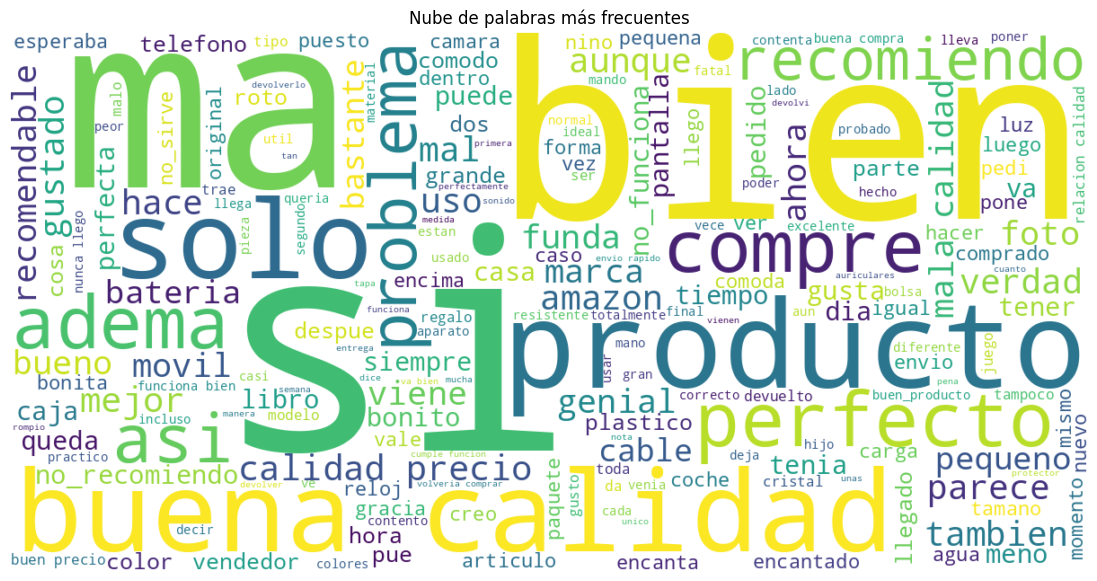

In [ ]:
all_text = " ".join(df["clean_text"])

wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=200
).generate(all_text)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras más frecuentes")
plt.show()


In [ ]:
df_binary = df[df["stars"].isin([1, 2, 4, 5])].copy()

def map_binary_sentiment(stars):
    return "Negativo" if stars <= 2 else "Positivo"

df_binary["sentiment"] = df_binary["stars"].apply(map_binary_sentiment)

df_binary["sentiment"].value_counts()


,count
sentiment,
Negativo,40000
Positivo,40000


In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_binary["sentiment"])

label_encoder.classes_


array(['Negativo', 'Positivo'], dtype=object)

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df_binary["clean_text"],
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

len(X_train), len(X_val), len(X_test)


(56000, 12000, 12000)

In [ ]:
def create_pipeline(params):
    return Pipeline([
        ("tfidf", TfidfVectorizer(
            min_df=params["min_df"],
            max_df=params["max_df"],
            ngram_range=params["ngram_range"],
        )),
        ("clf", LogisticRegression(
            C=params["C"],
            max_iter=3500,
            n_jobs=-1,
            class_weight="balanced",
            solver="lbfgs"
        ))
    ])







In [ ]:
# Optimización Bayesiana
!pip install optuna
import optuna

In [ ]:
import optuna
from sklearn.metrics import f1_score

def objective(trial):

    params = {
        "min_df": trial.suggest_int("min_df", 3, 4),
        "max_df": trial.suggest_float("max_df", 0.8, 0.81),
        "ngram_range": trial.suggest_categorical(
            "ngram_range", [(1,2)]

        ),
        "C": trial.suggest_float("C", 4, 4.5 ,log=True)
    }

    pipeline = create_pipeline(params)
    pipeline.fit(X_train, y_train)

    y_val_pred = pipeline.predict(X_val)

    return f1_score(y_val, y_val_pred)

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)


[I 2026-01-25 08:21:13,513] A new study created in memory with name: no-name-41ed9253-3d2a-4bde-a2cf-ff8ea88495bb
/tmp/ipython-input-2883384409.py:9: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
  "ngram_range": trial.suggest_categorical(
[I 2026-01-25 08:21:25,197] Trial 0 finished with value: 0.93255328040117 and parameters: {'min_df': 4, 'max_df': 0.8094370828008763, 'ngram_range': (1, 2), 'C': 4.226741357815506}. Best is trial 0 with value: 0.93255328040117.
/tmp/ipython-input-2883384409.py:9: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (1, 2) which is of type tuple.
  "ngram_range": trial.suggest_categorical(
[I 2026-01-25 08:21:35,422] Trial 1 finished with value: 0.933734436366675 and parameters: {'min_df': 3, 'max_df': 0.8091754294252734, 'ngram_range': (1, 2)

In [ ]:
pipeline = create_pipeline(study.best_params)

X_final = pd.concat([X_train, X_val])
y_final = np.concatenate([y_train, y_val])

pipeline.fit(X_final, y_final)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.8035694382790808, min_df=3,
                                 ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(C=4.176702069157328,
                                    class_weight='balanced', max_iter=3500,
                                    n_jobs=-1))])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [ ]:
def adjust_probability(cleaned_text, raw_prob):
    """
    cleaned_text: El texto que ya pasó por clean_text()
    raw_prob: La probabilidad (0 a 1) que devolvió pipeline.predict_proba() o ONNX
    """
    words = cleaned_text.split()
    total_weight = 0
    found_words = 0

    # Calcular peso semántico total
    for word in words:
        if word in SENTIMENT_WEIGHTS:
            total_weight += SENTIMENT_WEIGHTS[word]
            found_words += 1

    # Si no hay palabras clave, no tocamos la probabilidad del modelo
    if found_words == 0:
        return round(raw_prob, 3)

    # Factor de ajuste: multiplicamos el peso por un factor de sensibilidad (0.05)
    # Ejemplo: Si hay 2 palabras 'excelente' (+1.5 x 2 = 3), ajustamos +0.15 la prob.
    adjustment = total_weight * 0.15
    adjusted_prob = raw_prob + adjustment

    # Forzar límites entre 0 y 1
    adjusted_prob = min(max(adjusted_prob, 0), 1)

    # REGLA DE NEUTRALIDAD: Si hay palabras como 'regular' y el peso es bajo, forzamos a 0.5
    if any(w in ["regular", "normal", "ni_bueno_ni_malo"] for w in words) and abs(total_weight) < 0.5:
        return 0.5

    return round(float(adjusted_prob), 3)

# --- EJEMPLO DE USO ---
# p_modelo = pipeline.predict_proba([texto_limpio])[0][1]
# p_final = adjust_probability(texto_limpio, p_modelo)

In [ ]:
y_test_pred = pipeline.predict(X_test)

print("Accuracy (Test):", accuracy_score(y_test, y_test_pred))
print(classification_report(
    y_test,
    y_test_pred,
    target_names=label_encoder.classes_
))

Accuracy (Test): 0.93475
              precision    recall  f1-score   support

    Negativo       0.94      0.93      0.93      6000
    Positivo       0.93      0.94      0.93      6000

    accuracy                           0.93     12000
   macro avg       0.93      0.93      0.93     12000
weighted avg       0.93      0.93      0.93     12000



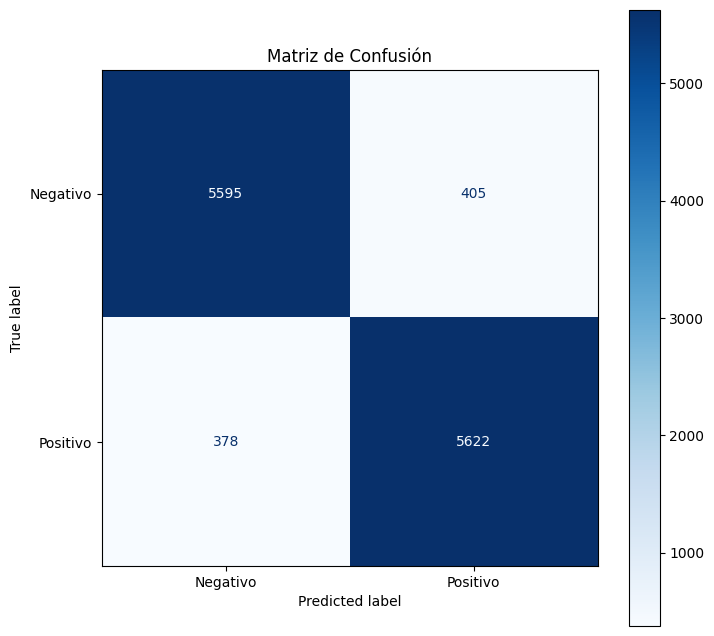

In [ ]:
cm = confusion_matrix(y_test, y_test_pred, labels=label_encoder.transform(label_encoder.classes_))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
def predict_with_neutral(texts, pipeline, pos_th=0.85, neg_th=0.15):
    """
    Clasifica textos en Positivo / Negativo / Neutro usando márgenes de probabilidad.
    Asume que 'texts' ya están preprocesados con clean_text().
    """

    # Probabilidad de la clase positiva
    probs = pipeline.predict_proba(texts)[:, 1]

    results = []
    for i, p in enumerate(probs):
        cleaned_text = texts[i]

        # Ajuste semántico por palabras ancla
        adjusted_prob = adjust_probability(cleaned_text, p)

        if adjusted_prob >= pos_th:
            results.append((
                "Positivo",
                round(float(adjusted_prob), 3)
            ))

        elif adjusted_prob <= neg_th:
            results.append((
                "Negativo",
                round(float(1 - adjusted_prob), 3)
            ))

        else:
            # Zona neutra: confianza baja / ambigua
            results.append((
                "Neutro",
                round(float(max(adjusted_prob, 1 - adjusted_prob)), 3)
            ))

    return results


In [ ]:
import joblib

# Guardar el pipeline completo (TF-IDF + modelo)
joblib.dump(pipeline, "sentiment_pipeline.joblib")

print("Pipeline guardado como sentiment_pipeline.joblib ")



Pipeline guardado como sentiment_pipeline.joblib 


### Cargar el modelo guardado y realizar predicciones

In [ ]:
import joblib

# Cargar el pipeline desde el archivo
loaded_pipeline = joblib.load("sentiment_pipeline.joblib")

print("Pipeline cargado exitosamente ")

Pipeline cargado exitosamente 


In [ ]:
new_texts = [
    "Este producto es increíble, lo recomiendo totalmente.",
    "No estoy seguro de si me gusta o no, es bastante promedio.",
    "Fue la peor experiencia de compra que he tenido, horrible.",
    "La entrega fue muy rápida y el artículo es exactamente como se describe.",
    "Está bien, pero podría ser mejor.",
    "Está bien, me gusta, pero huele mal.",
    "Excelente calidad, superó mis expectativas.",
    "No funciona como debería, me decepcionó bastante.",
    "El producto cumple su función, nada extraordinario.",
    "Muy buena compra, volvería a comprarlo sin dudar.",
    "El empaque llegó dañado, aunque el producto funciona.",
    "No vale el precio que tiene.",
    "Todo llegó en orden y a tiempo.",
    "La calidad es aceptable, pero esperaba más.",
    "Muy mala atención al cliente.",
    "Me encantó el diseño y los materiales.",
    "Funciona bien por ahora, veremos con el tiempo.",
    "Definitivamente no lo recomiendo.",
    "Buen producto para el precio que tiene.",
    "Es útil, aunque tiene algunos detalles incómodos.",
    "Excelente servicio y rápida respuesta.",
    "El producto llegó tarde y maltratado.",
    "No es malo, pero tampoco es bueno.",
    "Me sorprendió para bien, gran compra.",
    "No cumplió con lo que prometía.",
    "Está normal, cumple sin más.",
    "Muy satisfecho con la compra.",
    "No volvería a comprarlo.",
    "El material se siente barato.",
    "Funciona, pero esperaba mejor calidad.",
    "Muy buena relación calidad-precio.",
    "No era lo que esperaba.",
    "Todo perfecto, sin problemas.",
    "Regular, nada destacable.",
    "Me gustó mucho, lo recomiendo.",
    "Pésimo producto, no sirve.",
    "Hace su trabajo, aunque con fallas.",
    "Excelente, llegó antes de lo esperado.",
    "No está mal, pero hay opciones mejores.",
    "Estoy contento con el resultado.",
    "La experiencia fue negativa en general.",
    "Cumple lo básico.",
    "Muy buena compra, estoy satisfecho.",
    "No me gustó para nada.",
    "Es decente, sin ser excelente.",
    "La calidad es muy buena.",
    "Mal servicio y mala calidad.",
    "Funciona correctamente.",
    "Me dejó indiferente.",
    "Totalmente recomendado.",
    "increible"
]

# Limpiar los nuevos textos usando la función clean_text
clean_new_texts = [clean_text(text) for text in new_texts]

# Realizar predicciones con el modelo cargado
predictions = predict_with_neutral(clean_new_texts, loaded_pipeline)

for i, text in enumerate(new_texts):
    sentiment, probability = predictions[i]
    print(f"Texto: '{text}'")
    print(f"Sentimiento predicho: {sentiment} (Probabilidad: {probability:.2f})\n")

Texto: 'Este producto es increíble, lo recomiendo totalmente.'
Sentimiento predicho: Positivo (Probabilidad: 1.00)

Texto: 'No estoy seguro de si me gusta o no, es bastante promedio.'
Sentimiento predicho: Positivo (Probabilidad: 0.86)

Texto: 'Fue la peor experiencia de compra que he tenido, horrible.'
Sentimiento predicho: Negativo (Probabilidad: 1.00)

Texto: 'La entrega fue muy rápida y el artículo es exactamente como se describe.'
Sentimiento predicho: Positivo (Probabilidad: 0.99)

Texto: 'Está bien, pero podría ser mejor.'
Sentimiento predicho: Positivo (Probabilidad: 1.00)

Texto: 'Está bien, me gusta, pero huele mal.'
Sentimiento predicho: Neutro (Probabilidad: 0.72)

Texto: 'Excelente calidad, superó mis expectativas.'
Sentimiento predicho: Positivo (Probabilidad: 0.98)

Texto: 'No funciona como debería, me decepcionó bastante.'
Sentimiento predicho: Negativo (Probabilidad: 1.00)

Texto: 'El producto cumple su función, nada extraordinario.'
Sentimiento predicho: Positivo (Pro

In [ ]:
!pip install skl2onnx
!pip install onnxruntime




In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType

# Define the input type for the ONNX model
# The pipeline expects a list of strings (texts)
initial_type = [('input_text', StringTensorType([None, 1]))]

# Convert the sklearn pipeline to ONNX format
onx = convert_sklearn(
    loaded_pipeline,
    initial_types=initial_type,
    target_opset=13 # Opset version, often a good default for common ops
)

# Save the ONNX model to a file
with open("sentiment_pipeline.onnx", "wb") as f:
    f.write(onx.SerializeToString())

print("Pipeline convertido a ONNX y guardado como sentiment_pipeline.onnx ")

Pipeline convertido a ONNX y guardado como sentiment_pipeline.onnx 
